In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install kornia

### Options

In [3]:
class AugmentedOptions():
    pass

In [4]:
import sys
import argparse
import json
import os



def read_global_config():
    try:
        __location__ = os.path.realpath(os.path.join(
            os.getcwd(), os.path.dirname(__file__)))
        with open(os.path.join(__location__, 'global_config.json'), 'r') as f:
            global_config = json.load(f)
    except FileNotFoundError as fnf_error:
        print(fnf_error)
        exit(1)
    return global_config


def set_general_arguments(parser):
    general_arg = parser.add_argument_group('General')
    general_arg.add_argument('--confirm', type=str2bool,
                             default=True, help='promote confirmation for user')
    general_arg.add_argument('--use_cuda', type=str2bool,
                             default=True, help='use cuda')


def set_data_arguments(parser):
    data_arg = parser.add_argument_group('Data')
    data_arg.add_argument('--dataset_name', choices=['world_cup'],
                          type=str, default='world_cup', help='dataset name')
    data_arg.add_argument('--coord_conv_template', type=str2bool,
                          default=True, help='replace redundant channels tp XY grids')
    data_arg.add_argument('--template_path', type=str,
                          default='./data/world_cup_template.png', help='playfield template image')
    data_arg.add_argument('--need_single_image_normalization', type=str2bool,
                          default=True, help='normalize a single image')


def set_warp_arguments(parser):
    warp_arg = parser.add_argument_group('Warp')
    warp_arg.add_argument('--warp_type', choices=['homography'], type=str, default='homography', help='how to warp images')
    warp_arg.add_argument('--homo_param_method', choices=['deep_homography'], type=str, default='deep_homography', help='how to parameterize homography')


def set_dataset_paths(apt, global_config):
    if apt.dataset_name == 'world_cup':
        apt.test_dataset_path = global_config[apt.dataset_name]['test_dataset']
    else:
        raise ValueError('unknown dataset_name: {0}'.format(apt.dataset_name))
    return apt


def set_end2end_optim_options():

    global_config = read_global_config()

    parser = argparse.ArgumentParser()
    parser.add_argument('--test_mode', type=str2bool,
                        default=True, help='test mode')
    args, _ = parser.parse_known_args()
    training = not args.test_mode
    set_general_arguments(parser)
    set_data_arguments(parser)
    set_warp_arguments(parser)

    parser.add_argument('error_model', choices=['loss_surface'], help='type of network')
    parser.add_argument('guess_model', choices=['init_guess'], help='type of initial guess network')
    parser.add_argument('--prevent_neg', choices=['sigmoid'],
                        type=str, default='sigmoid', help='how to prevent negative error estimation')
    parser.add_argument('--load_weights_upstream', type=str, default=None,
                        help='load a pretrained set of weights for upstream initial guesser, you need to provide the model name')
    parser.add_argument('--load_weights_error_model', type=str, default=None,
                        help='load a pretrained set of weights for error model, you need to provide the model name')
    parser.add_argument('--out_dir', type=str,
                        default=global_config['out'], help='out directory')
    parser.add_argument('--need_spectral_norm_upstream', type=str2bool, default=False,
                        help='apply spectral norm to conv layers, for upstream initial guesser')
    parser.add_argument('--need_spectral_norm_error_model', type=str2bool,
                        default=True, help='apply spectral norm to conv layers, for error model')
    parser.add_argument('--group_norm_upstream', type=int,
                        default=0, help='0 is batch norm, otherwise means number of groups')
    parser.add_argument('--group_norm_error_model', type=int,
                        default=0, help='0 is batch norm, otherwise means number of groups')
    parser.add_argument('--optim_method', default='stn', choices=[
                        'stn'], help='optimization method')
    parser.add_argument('--optim_type', default='adam',
                        choices=['adam', 'sgd'], help='gradient descent optimizer type')
    parser.add_argument('--directh_part', default='lower', choices=[
                        'full', 'lower'], help='optimize the lower 4 corners, or full 4 corners')
    parser.add_argument('--optim_criterion', default='l1loss',
                        choices=['l1loss', 'mse'], help='criterion for optimization')
    parser.add_argument('--lr_optim', type=float,
                        default=1e-3, help='optimization learning rate')
    parser.add_argument('--optim_iters', type=int, default=400,
                        help='iterations for optimization')
    parser.add_argument('--batch_size', type=int, default=1,
                        help='batch size for optimization')
    parser.add_argument('--iou_space', default='part_and_whole', choices=[
                        'model_whole', 'model_part', 'part_and_whole'], help='space for iou calculation')
    parser.add_argument('--error_target', choices=['iou_whole'], type=str, default='iou_whole', help='error target for loss surface')

    apt = parser.parse_args()
    apt.command = ' '.join(sys.argv)
    apt.training = bool(training)
    assert apt.training is False, 'end2end_optim only support test mode'

    apt = set_dataset_paths(apt, global_config)
    check_cuda(apt)
    check_warp_params(apt)
    check_pretrained_weights(apt)

    if apt.confirm:
        confirm_opt(apt)
    else:
        print_opt(apt)

    return apt

In [5]:
import os
import json
import torch



def check_pretrained_weights(apt):
    pretrained_weights_option_list = ['load_weights_upstream', 'load_weights_error_model']
    for pretrained_weights_option in pretrained_weights_option_list:
        if hasattr(apt, pretrained_weights_option) and getattr(apt, pretrained_weights_option):
            weights_path = os.path.join(apt.out_dir,
                                        getattr(
                                            apt, pretrained_weights_option),
                                        'checkpoint.pth.tar')
            if not os.path.exists(weights_path):
                content_list = []
                content_list += ['Cannot find pretrained weights for {0}, at {1}'.format(
                    pretrained_weights_option, weights_path)]
                print_notification(content_list, 'ERROR')
                exit(1)
            if hasattr(apt, 'error_model'):
                check_prevent_neg(apt)


def check_warp_params(apt):
    apt.warp_dim = 8 if apt.warp_type == 'homography' else None


def check_prevent_neg(apt):
    if hasattr(apt, 'prevent_neg') and hasattr(apt, 'load_weights_error_model'):
        json_path = os.path.join(
            apt.out_dir, apt.load_weights_error_model, 'params.json')
        with open(json_path, 'r') as f:
            model_config = json.load(f)
        weights_prevent_neg = model_config['prevent_neg']
        if weights_prevent_neg != apt.prevent_neg:
            content_list = []
            content_list += [
                'Prevent negative method are different between the checkpoint and user options']
            print_notification(content_list, 'ERROR')
            exit(1)


def check_cuda(apt):
    if apt.use_cuda:
        assert torch.cuda.is_available()
        constant_var.USE_CUDA = apt.use_cuda

In [6]:
def str2bool(v: str) -> bool:
    return v.lower() in ('true', '1', 'yes', 'y', 't')


def print_opt(apt):
    content_list = []
    args = list(vars(apt))
    args.sort()
    for arg in args:
        content_list += [arg.rjust(25, ' ') + '  ' + str(getattr(apt, arg))]
    print_notification(content_list, 'OPTIONS')


def confirm_opt(apt):
    print_opt(apt)
    if not utils.confirm():
        exit(1)

### Utils

In [7]:


import torch

HAS_CUDA = torch.cuda.is_available()
USE_CUDA = False

In [8]:

def normalize_single_image(image):
    assert len(image.shape) == 3
    assert isinstance(image, torch.Tensor)
    img_mean = torch.mean(image, dim=(1, 2)).view(-1, 1, 1)
    img_std = image.contiguous().view(image.size(0), -1).std(-1).view(-1, 1, 1)
    image = (image - img_mean) / img_std
    return image


def rgb_template_to_coord_conv_template(rgb_template):
    assert isinstance(rgb_template, np.ndarray)
    assert rgb_template.min() >= 0.0
    assert rgb_template.max() <= 1.0
    rgb_template = np.mean(rgb_template, 2)
    x_coord, y_coord = np.meshgrid(np.linspace(0, 1, num=rgb_template.shape[1]),
                                   np.linspace(0, 1, num=rgb_template.shape[0]))
    coord_conv_template = np.stack((rgb_template, x_coord, y_coord), axis=2)
    return coord_conv_template

In [10]:

import random

import readline
import numpy as np
import torch
try:
    import kornia
except ModuleNotFoundError:
    pass

from kornia.geometry.transform import get_perspective_transform


def confirm(question='OK to continue?'):
    """
    Ask user to enter Y or N (case-insensitive).
    :return: True if the answer is Y.
    :rtype: bool
    """
    answer = ""
    while answer not in ["y", "n"]:
        answer = input(question + ' [y/n] ').lower()
    return answer == "y"


def print_notification(content_list, notifi_type='NOTIFICATION'):
    print(
        '---------------------- {0} ----------------------'.format(notifi_type))
    print()
    for content in content_list:
        print(content)
    print()
    print('-------------------------- END --------------------------')


def to_torch(np_array):
    if USE_CUDA:
        tensor = torch.from_numpy(np_array).float().cuda()
    else:
        tensor = torch.from_numpy(np_array).float()
    return torch.autograd.Variable(tensor, requires_grad=False)


def set_tensor_device(torch_var):
    if USE_CUDA:
        return torch_var.cuda()
    else:
        return torch_var


def set_model_device(model):
    if USE_CUDA:
        return model.cuda()
    else:
        return model


def to_numpy(cuda_var):
    return cuda_var.data.cpu().numpy()


def isnan(x):
    return x != x


def hasnan(x):
    return isnan(x).any()


def torch_img_to_np_img(torch_img):
    '''convert a torch image to matplotlib-able numpy image
    torch use Channels x Height x Width
    numpy use Height x Width x Channels
    Arguments:
        torch_img {[type]} -- [description]
    '''
    assert isinstance(torch_img, torch.Tensor), 'cannot process data type: {0}'.format(type(torch_img))
    if len(torch_img.shape) == 4 and (torch_img.shape[1] == 3 or torch_img.shape[1] == 1):
        return np.transpose(torch_img.detach().cpu().numpy(), (0, 2, 3, 1))
    if len(torch_img.shape) == 3 and (torch_img.shape[0] == 3 or torch_img.shape[0] == 1):
        return np.transpose(torch_img.detach().cpu().numpy(), (1, 2, 0))
    elif len(torch_img.shape) == 2:
        return torch_img.detach().cpu().numpy()
    else:
        raise ValueError('cannot process this image')


def np_img_to_torch_img(np_img):
    '''convert a numpy image to torch image
    numpy use Height x Width x Channels
    torch use Channels x Height x Width

    Arguments:
        np_img {[type]} -- [description]
    '''
    assert isinstance(np_img, np.ndarray), 'cannot process data type: {0}'.format(type(np_img))
    if len(np_img.shape) == 4 and (np_img.shape[3] == 3 or np_img.shape[3] == 1):
        return to_torch(np.transpose(np_img, (0, 3, 1, 2)))
    if len(np_img.shape) == 3 and (np_img.shape[2] == 3 or np_img.shape[2] == 1):
        return to_torch(np.transpose(np_img, (2, 0, 1)))
    elif len(np_img.shape) == 2:
        return to_torch(np_img)
    else:
        raise ValueError('cannot process this image')


def fix_randomness():
    random.seed(542)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(719)
    np.random.seed(121)


# the homographies map to coordinates in the range [-0.5, 0.5] (the ones in GT datasets)
BASE_RANGE = 0.5


def FULL_CANON4PTS_NP():
    return np.array([[-0.5, -0.5], [-0.5, 0.5], [0.5, 0.5], [0.5, -0.5]], dtype=np.float32)


def LOWER_CANON4PTS_NP():
    return np.array([[-0.5, 0.1], [-0.5, 0.5], [0.5, 0.5], [0.5, 0.1]], dtype=np.float32)


def get_perspective_transform(src, dst):


        def ax(p, q):
            ones = torch.ones_like(p)[..., 0:1]
            zeros = torch.zeros_like(p)[..., 0:1]
            return torch.cat(
                [p[:, 0:1], p[:, 1:2], ones, zeros, zeros, zeros,
                -p[:, 0:1] * q[:, 0:1], -p[:, 1:2] * q[:, 0:1]
                ], dim=1)

        def ay(p, q):
            ones = torch.ones_like(p)[..., 0:1]
            zeros = torch.zeros_like(p)[..., 0:1]
            return torch.cat(
                [zeros, zeros, zeros, p[:, 0:1], p[:, 1:2], ones,
                -p[:, 0:1] * q[:, 1:2], -p[:, 1:2] * q[:, 1:2]], dim=1)
        # we build matrix A by using only 4 point correspondence. The linear
        # system is solved with the least square method, so here
        # we could even pass more correspondence
        p = []
        p.append(ax(src[:, 0], dst[:, 0]))
        p.append(ay(src[:, 0], dst[:, 0]))

        p.append(ax(src[:, 1], dst[:, 1]))
        p.append(ay(src[:, 1], dst[:, 1]))

        p.append(ax(src[:, 2], dst[:, 2]))
        p.append(ay(src[:, 2], dst[:, 2]))

        p.append(ax(src[:, 3], dst[:, 3]))
        p.append(ay(src[:, 3], dst[:, 3]))

        # A is Bx8x8
        A = torch.stack(p, dim=1)

        # b is a Bx8x1
        b = torch.stack([
            dst[:, 0:1, 0], dst[:, 0:1, 1],
            dst[:, 1:2, 0], dst[:, 1:2, 1],
            dst[:, 2:3, 0], dst[:, 2:3, 1],
            dst[:, 3:4, 0], dst[:, 3:4, 1],
        ], dim=1)

        # solve the system Ax = b
        X = torch.linalg.solve(A,b)

        # create variable to return
        batch_size = src.shape[0]
        M = torch.ones(batch_size, 9, device=src.device, dtype=src.dtype)
        M[..., :8] = torch.squeeze(X, dim=-1)
        return M.view(-1, 3, 3)  # Bx3x3

In [11]:

import torch
import numpy as np



def warp_image(img, H, out_shape=None, input_grid=None):
    if out_shape is None:
        out_shape = img.shape[-2:]
    if len(img.shape) < 4:
        img = img[None]
    if len(H.shape) < 3:
        H = H[None]
    assert img.shape[0] == H.shape[0], 'batch size of images do not match the batch size of homographies'
    batchsize = img.shape[0]
    # create grid for interpolation (in frame coordinates)
    if input_grid is None:
        y, x = torch.meshgrid([
            torch.linspace(-BASE_RANGE, BASE_RANGE,
                           steps=out_shape[-2]),
            torch.linspace(-BASE_RANGE, BASE_RANGE,
                           steps=out_shape[-1])
        ])
        x = x.to(img.device)
        y = y.to(img.device)
    else:
        x, y = input_grid
    x, y = x.flatten(), y.flatten()

    # append ones for homogeneous coordinates
    xy = torch.stack([x, y, torch.ones_like(x)])
    xy = xy.repeat([batchsize, 1, 1])  # shape: (B, 3, N)
    # warp points to model coordinates
    xy_warped = torch.matmul(H, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)

    # we multiply by 2, since our homographies map to
    # coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
    xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
    x_warped, y_warped = torch.unbind(xy_warped, dim=1)
    # build grid
    grid = torch.stack([
        x_warped.view(batchsize, *out_shape[-2:]),
        y_warped.view(batchsize, *out_shape[-2:])
    ],
        dim=-1)

    # sample warped image
    warped_img = torch.nn.functional.grid_sample(
        img, grid, mode='bilinear', padding_mode='zeros')

    if hasnan(warped_img):
        print('nan value in warped image! set to zeros')
        warped_img[isnan(warped_img)] = 0

    return warped_img


def get_four_corners(homo_mat, canon4pts=None):
    '''
    calculate the 4 corners after transformation, from frame to template
    assuming the original 4 corners of the frame are [+-0.5, +-0.5]
    note: this function supports batch processing
    Arguments:
        homo_mat {[type]} -- [homography, shape: (B, 3, 3) or (3, 3)]

    Return:
        xy_warped -- torch.Size([B, 2, 4])
    '''
    # append ones for homogeneous coordinates
    if homo_mat.shape == (3, 3):
        homo_mat = homo_mat[None]
    assert homo_mat.shape[1:] == (3, 3)
    if canon4pts is None:
        canon4pts = to_torch(FULL_CANON4PTS_NP())
    assert canon4pts.shape == (4, 2)
    x, y = canon4pts[:, 0], canon4pts[:, 1]
    xy = torch.stack([x, y, torch.ones_like(x)])
    # warp points to model coordinates
    xy_warped = torch.matmul(homo_mat, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)
    xy_warped = xy_warped / (z_warped + 1e-8)
    return xy_warped

### Models

In [12]:

import os
import abc

import torch



class BaseRes18Model(abc.ABC):
    '''base model for resnet-18 based network
    '''

    @abc.abstractmethod
    def check_options(self):
        pass

    def load_pretrained_weights(self):
        # 1. load check point
        checkpoint_path = self._get_checkpoint_path()
        checkpoint = self._load_checkpoint(checkpoint_path)
        print(f"Checkpoint keys: {checkpoint.keys()}")
        # 2. verify check point
        self._verify_checkpoint(checkpoint)

        # 3. try loading weights
        key_name = 'model_state_dict'
        saved_weights = checkpoint[key_name]
        print("saved_weights : ", saved_weights.keys())
        try:
            self.load_state_dict(saved_weights)
        except RuntimeError:
            # handling the DataParallel weights problem
            try:
                weights = saved_weights
                weights = {k.replace('module.', ''): v for k,
                           v in weights.items()}
                self.load_state_dict(weights)
            except RuntimeError:
                try:
                    weights = saved_weights
                    weights = {'module.' + k: v for k, v in weights.items()}
                    self.load_state_dict(weights)
                except RuntimeError:
                    content_list = []
                    content_list += [
                        'Cannot load weights for {0}'.format(self.name)]
                    print_notification(content_list, 'ERROR')
                    exit(1)

        # 4. loaded
        content_list = []
        content_list += ['Weights loaded for {0}'.format(self.name)]
        content_list += ['From: {0}'.format(checkpoint_path)]
        print_notification(content_list)

    @abc.abstractmethod
    def _get_checkpoint_path(self):
        pass

    def _load_checkpoint(self, checkpoint_path):
        if os.path.isfile(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
        else:
            print(checkpoint_path)
            raise FileNotFoundError('model check point cannot found: {0}'.format(checkpoint_path))
        return checkpoint

    @abc.abstractmethod
    def _verify_checkpoint(self, checkpoint):
        pass

    def print_resnet_config(self, resnet_config):
        content_list = []
        content_list += ['Resnet backbone config for {0}'.format(self.name)]
        content_list += ['Spectral norm for resnet: {0}'.format(
            resnet_config.need_spectral_norm)]
        if resnet_config.group_norm == 0:
            content_list += ['Using BN for resnet']
        else:
            content_list += ['Using GN for resnet, number of groups: {0}'.format(resnet_config.group_norm)]
        content_list += ['Imagenet pretrain weights for resnet: {0}'.format(
            resnet_config.pretrained)]
        print_notification(content_list)

In [13]:

import os
import abc
from argparse import Namespace

import torch
import torch.nn.functional as F



class ErrorModelFactory():

    @staticmethod
    def get_error_model(apt):
        if apt.error_model == 'loss_surface':
            model = LossSurfaceRegressor(apt)
            model = set_model_device(model)
        else:
            raise ValueError(
                'unknown loss surface model: {0}'.format(apt.loss_surface_name))
        return model


class BaseErrorModel(BaseRes18Model, torch.nn.Module, abc.ABC):

    def __init__(self):
        super(BaseErrorModel, self).__init__()

    def check_options(self):
        if self.apt.error_model != self.name:
            content_list = []
            content_list += ['You are not using the correct class for training or eval']
            content_list += [
                'error_model in options: {0}, current error_model class: {1}'.format(self.apt.error_model, self.name)]
            print_notification(content_list, 'ERROR')
            exit(1)

    def make_value_positive(self, x):
        if self.prevent_neg == 'sigmoid':
            x = torch.sigmoid(x)
        else:
            content_list = []
            content_list += [
                'Unknown prevent_neg method: {0}'.format(self.prevent_neg)]
            print_notification(content_list, 'ERROR')
            exit(1)
        return x

    def load_pretrained_weights(self):
        '''load pretrained weights
        this function can load weights from another model.
        '''
        super().load_pretrained_weights()

    def _verify_checkpoint(self, checkpoint):
        if checkpoint['prevent_neg'] != self.apt.prevent_neg:
            content_list = []
            content_list += [
                'Prevent negative method are different between the checkpoint and user options']
            print_notification(content_list, 'ERROR')
            exit(1)

    def _get_checkpoint_path(self):
        checkpoint_path = os.path.join(self.apt.out_dir, self.apt.load_weights_error_model, 'checkpoint.pth.tar')
        return checkpoint_path

    def create_resnet_config(self):
        need_spectral_norm = False
        pretrained = False
        group_norm = 0
        if hasattr(self.apt, 'need_spectral_norm') and self.apt.need_spectral_norm:
            need_spectral_norm = True
        elif hasattr(self.apt, 'need_spectral_norm_error_model') and self.apt.need_spectral_norm_error_model:
            need_spectral_norm = True
        if hasattr(self.apt, 'group_norm'):
            group_norm = self.apt.group_norm
        elif hasattr(self.apt, 'group_norm_error_model'):
            group_norm = self.apt.group_norm_error_model

        if hasattr(self.apt, 'imagenet_pretrain') and self.apt.imagenet_pretrain:
            pretrained = True
        resnet_config = Namespace(need_spectral_norm=need_spectral_norm,
                                  pretrained=pretrained,
                                  group_norm=group_norm,
                                  )
        self.print_resnet_config(resnet_config)
        return resnet_config


class LossSurfaceRegressor(BaseErrorModel):


    def __init__(self, apt):
        self.apt = apt
        self.name = 'loss_surface'
        self.check_options()
        super(LossSurfaceRegressor, self).__init__()
        self.create_model()

    def create_model(self):
        self.prevent_neg = self.apt.prevent_neg
        if self.apt.error_target in ['iou_whole']:
            self.out_dim = 1
        else:
            raise ValueError(
                'unknown error target: {0}'.format(self.apt.error_target))
        self.input_features = 3 * 2
        resnet_config = self.create_resnet_config()
        self.feature_extractor = resnet18(resnet_config, pretrained=False, num_classes=self.out_dim,
                                                 input_features=self.input_features)
        if (hasattr(self.apt, 'load_weights_error_model') and self.apt.load_weights_error_model):
            self.load_pretrained_weights()

    def create_resnet_config(self):
        if hasattr(self.apt, 'imagenet_pretrain') and self.apt.imagenet_pretrain:
            content_list = []
            content_list += [
                'LossSurfaceRegressor do not support imagenet pretrained weights loading']
            print_notification(content_list, 'ERROR')
            exit(1)

        resnet_config = super().create_resnet_config()
        return resnet_config

    def forward(self, x):
        video, template = x
        image_stack = torch.cat((video, template), 1)  # stack along channel
        y = self.feature_extractor(image_stack)
        y = self.make_value_positive(y)
        return y

In [14]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def conv3x3(in_planes, out_planes, stride=1, need_spectral_norm=False):


    filter = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    if need_spectral_norm:
        return nn.utils.spectral_norm(filter, name='weight')
    else:
        return filter


def norm2d(planes, num_groups=0):
    if num_groups > 0:
        return nn.GroupNorm(num_groups, planes)
    else:
        return nn.BatchNorm2d(planes)


def conv1x1(in_planes, out_planes, stride=1):

    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, apt, inplanes, planes, stride=1, downsample=None, group_norm=0):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride, need_spectral_norm=apt.need_spectral_norm)
        self.bn1 = norm2d(planes, group_norm)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, need_spectral_norm=apt.need_spectral_norm)
        self.bn2 = norm2d(planes, group_norm)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, group_norm=0):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm2d(planes, group_norm)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm2d(planes, group_norm)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm2d(planes * self.expansion, group_norm)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, apt, block, layers, input_features: int = 3, num_classes: int = 1000, zero_init_residual=False, group_norm=0):
        super(ResNet, self).__init__()
        self.apt = apt
        self.inplanes = 64
        self.conv1 = nn.Conv2d(input_features, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm2d(64, group_norm)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], group_norm=group_norm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, group_norm=group_norm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, group_norm=group_norm)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, group_norm=group_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, group_norm=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm2d(planes * block.expansion, group_norm),
            )

        layers = []
        layers.append(block(self.apt, self.inplanes,
                            planes, stride, downsample, group_norm))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.apt, self.inplanes, planes, group_norm=group_norm))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(apt, pretrained=False, **kwargs):

    model = ResNet(apt, BasicBlock, [2, 2, 2, 2], group_norm=apt.group_norm, **kwargs)
    if pretrained:
        try:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
            content_list = []
            content_list += ['Imagenet pretrained weights fully loaded']
            print_notification(content_list)
        except:
            pretrained_dict = model_zoo.load_url(model_urls['resnet18'])
            # model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
            model_dict = model.state_dict()
            # 1. filter out unnecessary keys
            pretrained_dict = {k: v for k,
                               v in pretrained_dict.items() if k in model_dict}
            # 2. pop-out fc
            pretrained_dict.pop('fc.weight', None)
            pretrained_dict.pop('fc.bias', None)
            # 3. overwrite entries in the existing state dict
            model_dict.update(pretrained_dict)
            # 4. load the new state dict
            model.load_state_dict(model_dict)
            content_list = []
            content_list += ['Imagenet pretrained weights partially loaded']
            content_list += [str(pretrained_dict.keys())]
            print_notification(content_list)
    return model

In [15]:

import os
from argparse import Namespace

import torch


class InitialGuesserFactory(object):
    @staticmethod
    def get_initial_guesser(apt):
        if apt.guess_model == 'init_guess':
            model = InitialGuesser(apt)
            model = set_model_device(model)
        else:
            raise ValueError('unknown initial guess model:',
                             apt.loss_surface_name)
        return model


class InitialGuesser(BaseRes18Model, torch.nn.Module):


    def __init__(self, apt):
        self.apt = apt
        self.name = 'init_guess'
        self.check_options()
        super(InitialGuesser, self).__init__()
        self.create_model()

    def check_options(self):
        if self.apt.guess_model != self.name:
            content_list = []
            content_list += ['You are not using the correct class for training or eval']
            print_notification(content_list, 'ERROR')
            exit(1)

    def create_model(self):
        self.out_dim = 8
        self.input_features = 3
        resnet_config = self.create_resnet_config()
        self.feature_extractor = resnet18(resnet_config, pretrained=resnet_config.pretrained,
                                                 num_classes=self.out_dim, input_features=self.input_features)
        if (hasattr(self.apt, 'load_weights_upstream') and self.apt.load_weights_upstream):
            assert resnet_config.pretrained is False, 'pretrained weights or imagenet weights'
            self.load_pretrained_weights()

    def create_resnet_config(self):
        need_spectral_norm = False
        pretrained = False
        group_norm = 0
        if hasattr(self.apt, 'need_spectral_norm') and self.apt.need_spectral_norm:
            need_spectral_norm = self.apt.need_spectral_norm
        elif hasattr(self.apt, 'need_spectral_norm_upstream') and self.apt.need_spectral_norm_upstream:
            need_spectral_norm = self.apt.need_spectral_norm_error_model
        if hasattr(self.apt, 'group_norm'):
            group_norm = self.apt.group_norm
        elif hasattr(self.apt, 'group_norm_upstream'):
            group_norm = self.apt.group_norm_upstream
        if hasattr(self.apt, 'imagenet_pretrain') and self.apt.imagenet_pretrain:
            pretrained = True
        resnet_config = Namespace(need_spectral_norm=need_spectral_norm,
                                  pretrained=pretrained,
                                  group_norm=group_norm,
                                  )
        self.print_resnet_config(resnet_config)
        return resnet_config

    def forward(self, x):
        video = x
        y = self.feature_extractor(video)
        return y

    def load_pretrained_weights(self):

        super().load_pretrained_weights()

    def _verify_checkpoint(self, check_options):
        pass

    def _get_checkpoint_path(self):
        checkpoint_path = os.path.join(self.apt.out_dir, self.apt.load_weights_upstream, 'checkpoint.pth.tar')
        return checkpoint_path

In [16]:
import abc

import numpy as np



def get_homography_between_corners_and_default_canon4pts(corners, canon4pts_type: str):
    batch_size = corners.shape[0]
    if canon4pts_type == 'lower':
        lower_canon4pts = get_default_canon4pts(batch_size, canon4pts_type)
        homography = get_perspective_transform(lower_canon4pts, corners)
    elif canon4pts_type == 'full':
        full_canon4pts = get_default_canon4pts(batch_size, canon4pts_type)
        homography = get_perspective_transform(full_canon4pts, corners)
    else:
        raise ValueError('unknown canon4pts type')
    return homography


def get_default_canon4pts(batch_size, canon4pts_type: str):
    if canon4pts_type == 'lower':
        lower_canon4pts = LOWER_CANON4PTS_NP()
        lower_canon4pts = np.tile(lower_canon4pts, (batch_size, 1, 1))
        lower_canon4pts = to_torch(lower_canon4pts)
        return lower_canon4pts
    elif canon4pts_type == 'full':
        full_canon4pts = FULL_CANON4PTS_NP()
        full_canon4pts = np.tile(full_canon4pts, (batch_size, 1, 1))
        full_canon4pts = to_torch(full_canon4pts)
        return full_canon4pts
    else:
        raise ValueError('unknown canon4pts type')


class HomoInferenceGenerator(object):
    @staticmethod
    def get_homography_inference(apt):
        if apt.homo_param_method == 'deep_homography':
            homography = HomographyInferenceDeepHomo(apt)
        else:
            raise ValueError('unknown homography parameterization: {0}'.format(apt.homo_param_method))
        return homography


class HomoInference(abc.ABC):


    def __init__(self, apt):
        self.apt = apt
        self.check_options()
        self.build_models()

    def check_options(self):
        if self.apt.guess_model != 'init_guess':
            content_list = []
            content_list += ['HomoInference currently only support init_guess as upstream']
            print_notification(content_list, 'ERROR')
            exit(1)

    def build_models(self):
        # self.upstream = init_guesser.InitialGuesser(self.apt)
        self.upstream = InitialGuesserFactory.get_initial_guesser(
            self.apt)
        self.upstream = set_model_device(self.upstream)
        self.upstream.eval()

    def refresh(self):
        self.upstream.load_pretrained_weights()

    def get_upstream_params(self):
        assert self.apt.guess_model == 'init_guess'
        return self.upstream.parameters()

    def get_training_status(self) -> bool:
        return self.upstream.training

    @abc.abstractmethod
    def infer_upstream_homography(self, frame):
        pass

    @abc.abstractmethod
    def infer_upstream_corners(self, frame):
        pass


class HomographyInferenceDeepHomo(HomoInference):

    def infer_upstream_corners(self, frame):
        self.upstream.eval()
        inferred_corners_orig = self.upstream(frame)
        inferred_corners_orig = inferred_corners_orig.reshape(-1, 2, 4)
        inferred_corners_orig = inferred_corners_orig.permute(0, 2, 1)
        return inferred_corners_orig

    def infer_upstream_homography(self, frame):
        batch_size = frame.shape[0]
        inferred_corners_orig = self.infer_upstream_corners(frame)
        lower_canon4pts = get_default_canon4pts(batch_size, canon4pts_type='lower')
        homography = get_perspective_transform(lower_canon4pts, inferred_corners_orig)
        return homography

In [17]:

import abc

import numpy as np
import torch
from tqdm import tqdm



class End2EndOptimFactory(object):
    @staticmethod
    def get_end_2_end_optimization_model(apt):
        if apt.optim_method == 'stn':
            model = End2EndOptimSTN(apt)
        else:
            raise ValueError('unknown optimization method:', apt.optim_method)
        return model


class End2EndOptim(abc.ABC):


    def __init__(self, apt):
        self.apt = apt
        self.check_options()
        self.build_criterion()
        self.build_models()
        self.build_homography_inference()
        self.lambdas = None

    def check_options(self):
        valid_models = ['loss_surface']
        if self.apt.error_model not in valid_models:
            content_list = []
            content_list += [
                'End2EndOptim current only support {0} as optimization objective'.format(valid_models)]
            print_notification(content_list, 'ERROR')
            exit(1)
        assert self.apt.optim_iters > 0, 'optimization iterations should be larger than 0'

    def build_criterion(self):
        if self.apt.optim_criterion == 'l1loss':
            self.criterion = torch.nn.L1Loss(reduction='sum')
        elif self.apt.optim_criterion == 'mse':
            self.criterion = torch.nn.MSELoss(reduction='sum')
        else:
            raise ValueError('unknown optimization criterion: {0}'.format(
                self.apt.optim_criterion))

    def build_models(self):
        self.optim_net = ErrorModelFactory.get_error_model(
            self.apt)
        self.optim_net = set_model_device(self.optim_net)
        self.optim_net.eval()
        if self.apt.error_target == 'iou_whole':
            self.target_dist = torch.ones((1, 1), requires_grad=False)
            self.target_dist = set_tensor_device(self.target_dist)
        else:
            raise ValueError(
                'unknown error target: {0}'.format(self.apt.error_target))

    def build_homography_inference(self):
        self.homography_inference = HomoInferenceGenerator.get_homography_inference(
            self.apt)

    def create_gd_optimizer(self, params):
        optim_list = [{"params": params, "lr": self.apt.lr_optim}]
        if self.apt.optim_type == 'adam':
            optim = torch.optim.Adam(optim_list)
        elif self.apt.optim_type == 'sgd':
            optim = torch.optim.SGD(optim_list)
        else:
            raise ValueError(
                'unknown optimization type: {0}'.format(self.apt.optim_type))
        return optim

    def first_order_main_optimization_loop(self, frame, template, optim_tools, get_corners_fun, corner_to_mat_fun):
        loss_hist = []
        corners_optim_list = []
        optimizer = optim_tools['optimizer']
        B = frame.shape[0]
        for i in tqdm(range(0, self.apt.optim_iters)):
            corners_optim = get_corners_fun()
            corners_optim_list.append(corners_optim)
            inferred_transformation_mat = corner_to_mat_fun(corners_optim)
            warped_tmp = warp_image(
                template, inferred_transformation_mat, out_shape=frame.shape[-2:])
            inferred_dist = self.optim_net((frame, warped_tmp))
            optim_loss = self.get_loss(inferred_dist, self.target_dist.repeat(B, 1))
            loss_hist.append(optim_loss.clone().detach().cpu().numpy())
            if torch.isnan(optim_loss.data):
                assert 0, 'loss is nan during optimization'
            else:
                optimizer.zero_grad()
                optim_loss.backward()
                optimizer.step()
            if optim_loss.data < 0.000000:
                break
        loss_hist = np.array(loss_hist)
        return loss_hist, corners_optim_list

    def get_loss(self, output, target):
        optim_loss = self.criterion(output, target)
        return optim_loss

    def main_optimization_loop(self, frame, template, optim_tools, get_corners_fun, corner_to_mat_fun):
        if self.apt.optim_type == 'adam' or 'sgd':
            loss_hist, corners_optim_list = self.first_order_main_optimization_loop(
                frame, template, optim_tools, get_corners_fun, corner_to_mat_fun)
        else:
            raise ValueError(
                'unknown optimization type: {0}'.format(self.apt.optim_type))
        return loss_hist, corners_optim_list

    @abc.abstractmethod
    def optim(self, frame, template, refresh=True):
        pass


class End2EndOptimSTN(End2EndOptim):
    def optim(self, frame, template, refresh=True):
        def get_corners_stn():
            return self.homography_inference.infer_upstream_corners(frame)

        def corner_to_mat_stn(corners):
            return get_homography_between_corners_and_default_canon4pts(corners, 'lower')

        if refresh:
            self.homography_inference.refresh()
        assert self.homography_inference.get_training_status() is False, 'set model to eval mode at optimization stage'
        assert self.optim_net.training is False, 'set model to eval mode at optimization stage'
        B = frame.shape[0]
        assert B == 1, 'STN optimization only support one image at a time'

        upstream_homography = self.homography_inference.infer_upstream_homography(frame)
        optim = self.create_gd_optimizer(params=self.homography_inference.get_upstream_params())
        optim_tools = {'optimizer': optim}
        loss_hist, corners_optim_list = self.main_optimization_loop(frame,
                                                                    template,
                                                                    optim_tools,
                                                                    get_corners_stn,
                                                                    corner_to_mat_stn)
        orig_homography = upstream_homography
        optim_homography = get_homography_between_corners_and_default_canon4pts(corners_optim_list[loss_hist.argmin()], 'lower')
        return orig_homography, optim_homography

### Train_Initialguessor

In [ ]:
def reconstruct_homography(predictions):
    """
    Reconstruct the full 3x3 homography matrix from 8 parameters.
    Args:
        predictions: Tensor of size (batch_size, 8)
    Returns:
        Tensor of size (batch_size, 3, 3)
    """
    # Ensure predictions have the correct shape
    if predictions.dim() == 3 and predictions.size(-1) == 1:
        predictions = predictions.squeeze(-1)  # Remove trailing dimension

    batch_size = predictions.size(0)
    h_matrix = torch.cat([predictions, torch.ones(batch_size, 1).to(predictions.device)], dim=1)
    return h_matrix.view(batch_size, 3, 3)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_initial_guesser(model, train_loader, criterion, optimizer, device, epochs=10):
    """
    Train the InitialGuesser model.

    Args:
        model: The InitialGuesser model instance.
        train_loader: DataLoader for training data.
        criterion: Loss function (e.g., MSELoss).
        optimizer: Optimizer (e.g., Adam).
        device: Device to run the training (CPU or GPU).
        epochs: Number of epochs to train.
    """
    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0

        for images, gt_homographies in train_loader:
            images, gt_homographies = images.to(device), gt_homographies.to(device)

            # Forward pass
            predictions = model(images)
            print(f"Predictions shape: {predictions.shape}")

            print(f"ground_homography shape: {gt_homographies.shape}")
            predictions_h = reconstruct_homography(predictions)  # (batch_size, 3, 3)
            gt_homographies_h = reconstruct_homography(gt_homographies)  # (batch_size, 3, 3)
            # Compute loss
            loss = criterion(predictions_h, gt_homographies_h)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")



In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class HomographyDataset(Dataset):
    def __init__(self, image_paths, homography_dict, transform=None):
        """
        Args:
            image_paths: List of paths to input images.
            homography_dict: Dictionary mapping image filenames to homographies.
            transform: Transformations to apply to the images.
        """
        self.image_paths = image_paths
        self.homography_dict = homography_dict
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = image.resize((256, 256))  # Resize for consistency

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image) / 255.0).permute(2, 0, 1).float()

        # Retrieve ground truth homography
        filename = image_path.split("/")[-1]
        filename = filename.split(".")[0]
        gt_homography = torch.tensor(self.homography_dict[filename]).view(-1)[:8].float()   # First 8 elements only


        return image, gt_homography


In [ ]:
from torchvision import transforms

with open('/content/gdrive/MyDrive/CV_finalProj/modified_train_homo_data.json', 'r') as file:
    ground_homo_dict = json.load(file)

for i in ground_homo_dict.keys():
  rows = ground_homo_dict[i].strip("[]").split("\n")
  ground_homo = np.array([list(map(float, row.replace("]", "").replace("[", "").split())) for row in rows])
  ground_homo_dict[i] = ground_homo

homography_dict = ground_homo_dict
image_paths = []
image_folder = '/content/gdrive/MyDrive/soccer_data/raw/train_val'
for fl in os.listdir(image_folder):
    f = os.path.join(image_folder, fl)
    if f[-3:] == "jpg":
      image_paths.append(f)


transform = transforms.Compose([transforms.ToTensor()])
dataset = HomographyDataset(image_paths, homography_dict, transform)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InitialGuesser(apt)
model.to(device)

---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------


<ipython-input-12-3ef2502c501b>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint keys: dict_keys(['epoch', 'iteration', 'optim_state_dict', 'model_state_dict'])
saved_weights :  odict_keys(['feature_extractor.conv1.weight', 'feature_extractor.bn1.weight', 'feature_extractor.bn1.bias', 'feature_extractor.bn1.running_mean', 'feature_extractor.bn1.running_var', 'feature_extractor.bn1.num_batches_tracked', 'feature_extractor.layer1.0.conv1.weight', 'feature_extractor.layer1.0.bn1.weight', 'feature_extractor.layer1.0.bn1.bias', 'feature_extractor.layer1.0.bn1.running_mean', 'feature_extractor.layer1.0.bn1.running_var', 'feature_extractor.layer1.0.bn1.num_batches_tracked', 'feature_extractor.layer1.0.conv2.weight', 'feature_extractor.layer1.0.bn2.weight', 'feature_extractor.layer1.0.bn2.bias', 'feature_extractor.layer1.0.bn2.running_mean', 'feature_extractor.layer1.0.bn2.running_var', 'feature_extractor.layer1.0.bn2.num_batches_tracked', 'feature_extractor.layer1.1.conv1.weight', 'feature_extractor.layer1.1.bn1.weight', 'feature_extractor.layer1.1.bn1.bias', '

InitialGuesser(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
criterion = nn.MSELoss()  # Loss function for homography regression
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,  # Learning rate: 0.0001
    weight_decay=1e-5,  # Regularization term
    betas=(0.9, 0.999)  # Default beta1 and beta2 values
)
  # Optimizer
epochs = 100  # Number of training epochs


In [ ]:
train_initial_guesser(model, train_loader, criterion, optimizer, device, epochs)


Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([10, 8])
Predictions shape: torch.Size([10, 8])
ground_homography shape: torch.Size([

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CV_finalProj/out_new/pretrained_init_guess/checkpoint.pth.tar")


In [ ]:
import torch

# Load the original checkpoint
checkpoint = torch.load("/content/gdrive/MyDrive/CV_finalProj/out_new/pretrained_init_guess/checkpoint.pth.tar")

# Restructure the checkpoint if needed
new_checkpoint = {'model_state_dict': checkpoint}  # Add the expected key
torch.save(new_checkpoint, "/content/gdrive/MyDrive/CV_finalProj/out_new/pretrained_init_guess/checkpoint.pth.tar")


<ipython-input-119-d3522e8e265b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/gdrive/MyDrive/CV_finalProj/out_new/pretrained_init_guess

### Main Code

In [18]:
import os

import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import cv2

In [21]:
# if want to run on CPU, please make it False
USE_CUDA = True


# if GPU is RTX 20XX, please disable cudnn
torch.backends.cudnn.enabled = True

In [22]:
# set some options
apt = AugmentedOptions()
apt.batch_size = 1
apt.coord_conv_template = True
apt.error_model = 'loss_surface'
apt.error_target = 'iou_whole'
apt.goal_image_path = '/content/gdrive/MyDrive/CV_finalProj/soccer_data_segmented/3.jpg'

apt.guess_model = 'init_guess'
apt.homo_param_method = 'deep_homography'
apt.load_weights_error_model = '/content/gdrive/MyDrive/CV_finalProj/out_old/pretrained_loss_surface'
apt.load_weights_upstream = '/content/gdrive/MyDrive/CV_finalProj/out_old/pretrained_init_guess'
apt.lr_optim = 1e-5
apt.need_single_image_normalization = True
apt.need_spectral_norm_error_model = True
apt.need_spectral_norm_upstream = False
apt.optim_criterion = 'l1loss'
apt.optim_iters = 200
apt.optim_method = 'stn'
apt.optim_type = 'adam'
apt.out_dir = './out'
apt.prevent_neg = 'sigmoid'
apt.template_path = '/content/gdrive/MyDrive/CV_finalProj/world_cup_template.png'
apt.warp_dim = 8
apt.warp_type = 'homography'

<ipython-input-23-5716e035edb7>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  goal_image = imageio.imread(apt.goal_image_path, pilmode='RGB')


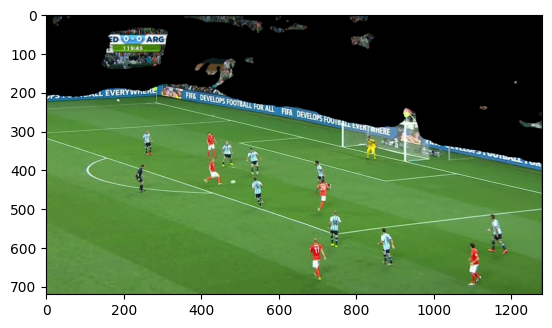

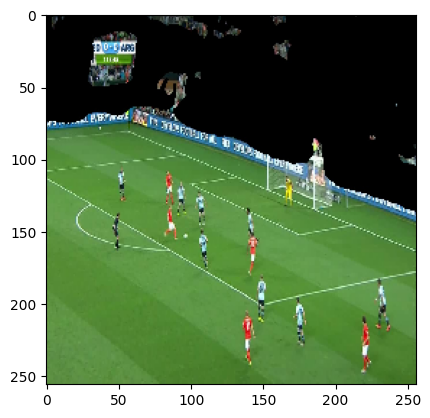

In [23]:
# read original image
goal_image = imageio.imread(apt.goal_image_path, pilmode='RGB')
plt.imshow(goal_image)
plt.show()
# resize image to square shape, 256 * 256, and squash to [0, 1]
pil_image = Image.fromarray(np.uint8(goal_image))
pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
goal_image = np.array(pil_image)
plt.imshow(goal_image)
plt.show()
# covert np image to torch image, and do normalization
goal_image = np_img_to_torch_img(goal_image)
if apt.need_single_image_normalization:
    goal_image = normalize_single_image(goal_image)


<ipython-input-24-eec357a0f6f3>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  template_image = imageio.imread(apt.template_path, pilmode='RGB')


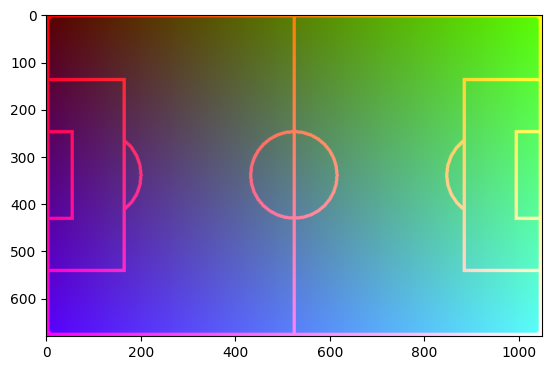

In [24]:
# read template image
template_image = imageio.imread(apt.template_path, pilmode='RGB')
template_image = template_image / 255.0
if apt.coord_conv_template:
    template_image = rgb_template_to_coord_conv_template(template_image)
plt.imshow(template_image)
plt.show()
# covert np image to torch image, and do normalization
template_image = np_img_to_torch_img(template_image)
if apt.need_single_image_normalization:
    template_image = normalize_single_image(template_image)

In [25]:
e2e = End2EndOptimFactory.get_end_2_end_optimization_model(apt)

---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------


<ipython-input-12-cd44b474fec6>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint keys: dict_keys(['epoch', 'iteration', 'optim_state_dict', 'model_state_dict', 'prevent_neg'])
saved_weights :  odict_keys(['feature_extractor.conv1.weight', 'feature_extractor.bn1.weight', 'feature_extractor.bn1.bias', 'feature_extractor.bn1.running_mean', 'feature_extractor.bn1.running_var', 'feature_extractor.bn1.num_batches_tracked', 'feature_extractor.layer1.0.conv1.weight_orig', 'feature_extractor.layer1.0.conv1.weight_u', 'feature_extractor.layer1.0.conv1.weight_v', 'feature_extractor.layer1.0.bn1.weight', 'feature_extractor.layer1.0.bn1.bias', 'feature_extractor.layer1.0.bn1.running_mean', 'feature_extractor.layer1.0.bn1.running_var', 'feature_extractor.layer1.0.bn1.num_batches_tracked', 'feature_extractor.layer1.0.conv2.weight_orig', 'feature_extractor.layer1.0.conv2.weight_u', 'feature_extractor.layer1.0.conv2.weight_v', 'feature_extractor.layer1.0.bn2.weight', 'feature_extractor.layer1.0.bn2.bias', 'feature_extractor.layer1.0.bn2.running_mean', 'feature_extractor.

In [26]:
orig_homography, optim_homography = e2e.optim(goal_image[None], template_image)

<ipython-input-12-cd44b474fec6>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint keys: dict_keys(['epoch', 'iteration', 'optim_state_dict', 'model_state_dict'])
saved_weights :  odict_keys(['feature_extractor.conv1.weight', 'feature_extractor.bn1.weight', 'feature_extractor.bn1.bias', 'feature_extractor.bn1.running_mean', 'feature_extractor.bn1.running_var', 'feature_extractor.bn1.num_batches_tracked', 'feature_extractor.layer1.0.conv1.weight', 'feature_extractor.layer1.0.bn1.weight', 'feature_extractor.layer1.0.bn1.bias', 'feature_extractor.layer1.0.bn1.running_mean', 'feature_extractor.layer1.0.bn1.running_var', 'feature_extractor.layer1.0.bn1.num_batches_tracked', 'feature_extractor.layer1.0.conv2.weight', 'feature_extractor.layer1.0.bn2.weight', 'feature_extractor.layer1.0.bn2.bias', 'feature_extractor.layer1.0.bn2.running_mean', 'feature_extractor.layer1.0.bn2.running_var', 'feature_extractor.layer1.0.bn2.num_batches_tracked', 'feature_extractor.layer1.1.conv1.weight', 'feature_extractor.layer1.1.bn1.weight', 'feature_extractor.layer1.1.bn1.bias', '

<ipython-input-17-6449e3ec9d70>:81: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, self.apt.optim_iters)):


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


<ipython-input-27-2e5ab2a1810a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  goal_image_draw = imageio.imread(apt.goal_image_path, pilmode='RGB')
<ipython-input-27-2e5ab2a1810a>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  template_image_draw = imageio.imread(apt.template_path, pilmode='RGB')


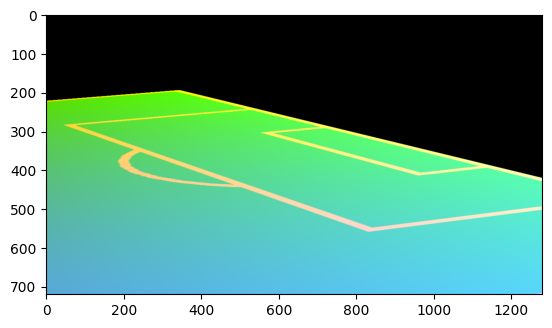

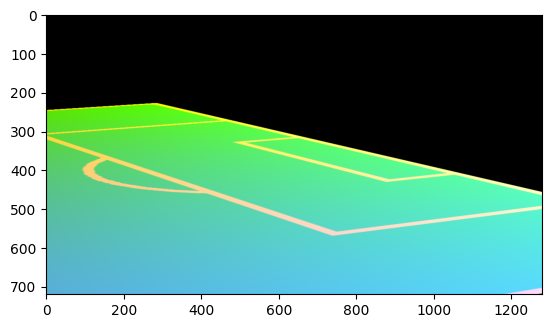

In [27]:
# reload image and template for visualization
# overload goal image
goal_image_draw = imageio.imread(apt.goal_image_path, pilmode='RGB')
goal_image_draw = goal_image_draw / 255.0
outshape = goal_image_draw.shape[0:2]

# overload template image
template_image_draw = imageio.imread(apt.template_path, pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = np_img_to_torch_img(template_image_draw)

# warp template image with initial guess
warped_tmp_orig = warp_image(template_image_draw, orig_homography, out_shape=outshape)[0]
warped_tmp_orig = torch_img_to_np_img(warped_tmp_orig)
plt.imshow(warped_tmp_orig)
plt.show()

# warp template image with optimized guess
warped_tmp_optim = warp_image(template_image_draw, optim_homography, out_shape=outshape)[0]
warped_tmp_optim = torch_img_to_np_img(warped_tmp_optim)
plt.imshow(warped_tmp_optim)
plt.show()

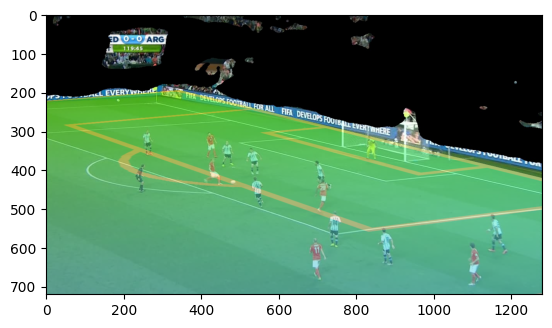

In [28]:
# show initial guess overlay
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_orig[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_orig[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.show()

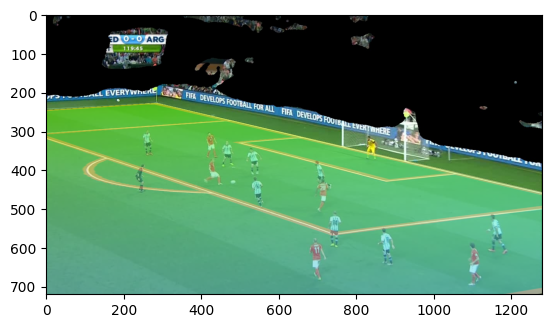

In [29]:
# show optimized guess overlay
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_optim[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_optim[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.show()

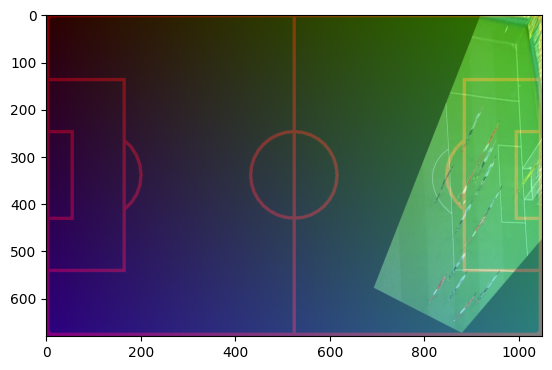

In [ ]:
# show original top-down view
H_inv = torch.inverse(orig_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp_image(np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(torch_img_to_np_img(warped_frm)*0.5+torch_img_to_np_img(template_image_draw)*0.5)
plt.show()

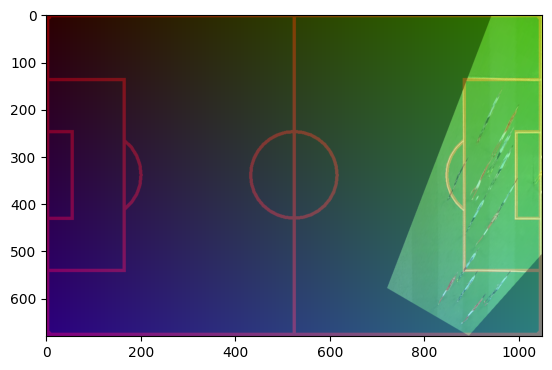

In [ ]:
# show optimized top-down view
H_inv = torch.inverse(optim_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp_image(np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(torch_img_to_np_img(warped_frm)*0.5+torch_img_to_np_img(template_image_draw)*0.5)
plt.show()

<ipython-input-48-9f36ffb45eb1>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow( imageio.imread(apt.goal_image_path, pilmode='RGB'))


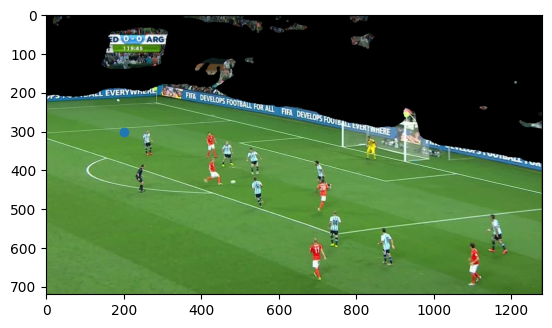

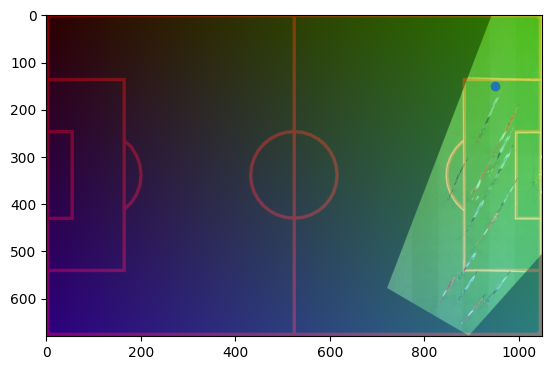

In [ ]:
# warp a point from frame to template
frame_point = np.array([200, 300])
plt.imshow( imageio.imread(apt.goal_image_path, pilmode='RGB'))
plt.scatter(frame_point[0], frame_point[1])
plt.show()

x = torch.tensor(frame_point[0] / 1280 - 0.5).float()
y = torch.tensor(frame_point[1] / 720 - 0.5).float()
xy = torch.stack([x, y, torch.ones_like(x)])
xy_warped = torch.matmul(optim_homography.cpu(), xy)  # H.bmm(xy)
xy_warped, z_warped = xy_warped.split(2, dim=1)

# we multiply by 2, since our homographies map to
# coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
x_warped, y_warped = torch.unbind(xy_warped, dim=1)
# [-1, 1] -> [0, 1]
x_warped = (x_warped.item() * 0.5 + 0.5) * 1050
y_warped = (y_warped.item() * 0.5 + 0.5) * 680

plt.imshow(torch_img_to_np_img(warped_frm)*0.5+torch_img_to_np_img(template_image_draw)*0.5)
plt.scatter(x_warped, y_warped)
plt.show()

#### Evaluation

In [ ]:
import os

In [ ]:
homo_gen_dict = {}
segmented_train_images = '/content/gdrive/MyDrive/CV_finalProj/soccer_data_segmented'
for fl in os.listdir(segmented_train_images):
    f = os.path.join(segmented_train_images, fl)
    if f[-3:] == "jpg":
      goal_image = imageio.imread(f, pilmode='RGB')
      pil_image = Image.fromarray(np.uint8(goal_image))
      pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
      goal_image = np.array(pil_image)
      goal_image = np_img_to_torch_img(goal_image)
      if apt.need_single_image_normalization:
          goal_image = normalize_single_image(goal_image)
      orig_homography, optim_homography = e2e.optim(goal_image[None], template_image)
      homo_gen_dict[fl.split('.')[0]] = optim_homography.cpu().detach().numpy()

<ipython-input-34-35951a699cd1>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  goal_image = imageio.imread(f, pilmode='RGB')
<ipython-input-14-1ec9a75ff267>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


<ipython-input-19-f785d9f66c83>:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, self.apt.optim_iters)):


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/gdrive/MyDrive/CV_finalProj/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
homo_gen_dict

{'1': array([[[ 0.5027663 , -0.00314214,  0.21599425],
         [ 0.16673656,  2.433554  , -0.23621048],
         [-0.06785932,  2.5402558 ,  1.        ]]], dtype=float32),
 '10': array([[[ 0.5850308 , -0.11854175, -0.2921204 ],
         [-0.25496376,  2.5499418 , -0.3416839 ],
         [-0.1690697 ,  2.8716316 ,  1.        ]]], dtype=float32),
 '100': array([[[ 0.40626782,  0.01509987, -0.13194412],
         [-0.11359776,  1.5785905 ,  0.11811414],
         [ 0.01879753,  1.3071269 ,  1.        ]]], dtype=float32),
 '101': array([[[ 4.1612405e-01,  4.8231361e-03, -1.9012859e-01],
         [-1.4593624e-01,  1.6146395e+00, -7.6463372e-02],
         [ 1.3310611e-03,  1.3962792e+00,  1.0000000e+00]]], dtype=float32),
 '102': array([[[ 0.37721458, -0.02506945,  0.34995818],
         [ 0.28062335,  1.5433472 ,  0.05433225],
         [ 0.03366849,  1.2667367 ,  1.        ]]], dtype=float32),
 '103': array([[[ 0.4113491 ,  0.00777452, -0.1157781 ],
         [-0.10180955,  1.5991836 ,  0.01796

In [ ]:
# Evaluation is done here by taking in the file generated by HomographyTransform_note.ipynb notebook
with open('/content/gdrive/MyDrive/CV_finalProj/modified_train_homo_data.json', 'r') as file:
    ground_homo_dict = json.load(file)

In [ ]:
import numpy as np
import ast

In [ ]:
f_norm_dict = {}
for i in homo_gen_dict.keys():
  gen_homo = homo_gen_dict[i]
  rows = ground_homo_dict[i].strip("[]").split("\n")
  ground_homo = np.array([list(map(float, row.replace("]", "").replace("[", "").split())) for row in rows])
  diff = np.abs(gen_homo - ground_homo)
  f_norm_dict[i] = np.linalg.norm(diff[0], 'fro')


In [ ]:
f_norm_dict = {key: value for key, value in sorted(f_norm_dict.items(), key=lambda x: int(x[0]))}

In [ ]:
from itertools import islice
dict(islice(f_norm_dict.items(), 5))

{'1': 0.42936432298318433,
 '2': 0.0886730163688396,
 '3': 0.08703007231517794,
 '4': 0.0774285284413659,
 '5': 0.13380189137033804}

In [ ]:
average_value = sum(f_norm_dict.values()) / len(f_norm_dict)

print("Average fnorm value : ",average_value)

Average fnorm value :  0.16743654260525387


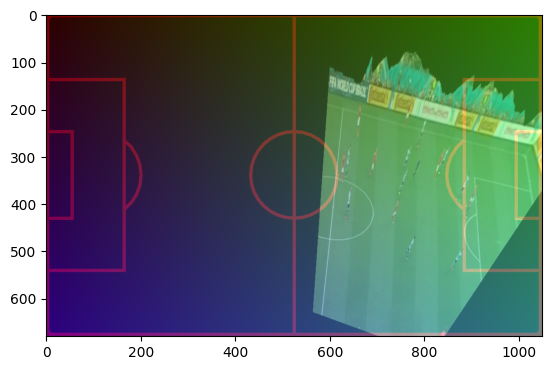

<Figure size 640x480 with 0 Axes>

In [ ]:
#Top-down view of optimal generated matrix
H_inv = torch.inverse(optim_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp_image(np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(torch_img_to_np_img(warped_frm)*0.5+torch_img_to_np_img(template_image_draw)*0.5)
plt.show()
plt.savefig("/content/gdrive/MyDrive/segmented_images/generated.jpg")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


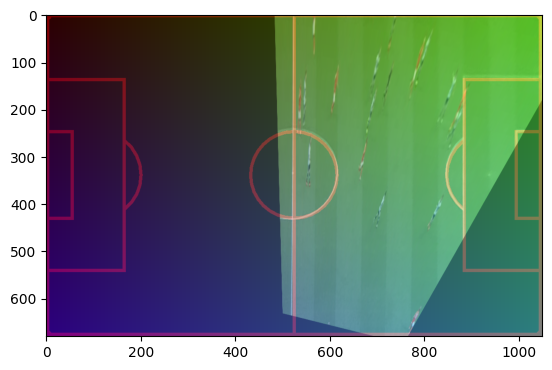

In [ ]:
# Top-down view of ground truth matrix
rows = ground_homo_dict['1'].strip("[]").split("\n")
ground_homo = np.array([list(map(float, row.replace("]", "").replace("[", "").split())) for row in rows])
ground_homo = torch.tensor(ground_homo).to('cuda').float()


H_inv = torch.inverse(ground_homo)
outshape = template_image_draw.shape[1:3]
warped_frm = warp_image(np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(torch_img_to_np_img(warped_frm)*0.5+torch_img_to_np_img(template_image_draw)*0.5)
plt.show()



#### Result

In [ ]:
import numpy as np

# Define a function to parse the coordinates from the text file
def parse_coordinates(file_path):
    source_points = []
    source_points2 = []
    source_points3 = []

    with open(file_path, 'r') as file:
        group = None
        for line in file:
            line = line.strip()
            if line.startswith("Group 1 Coordinates:"):
                group = 1
            elif line.startswith("Group 2 Coordinates:"):
                group = 2
            elif line.startswith("Group 3 Coordinates:"):
                group = 3
            elif line.startswith("("):  # This indicates a coordinate line
                x, y = map(int, line.strip("()").split(","))
                if group == 1:
                    source_points.append((x, y))
                elif group == 2:
                    source_points2.append((x, y))
                elif group == 3:
                    source_points3.append((x, y))
    return np.array(source_points, dtype=np.float32), np.array(source_points2, dtype=np.float32), np.array(source_points3, dtype=np.float32)

# Example usage
file_path = "/content/gdrive/MyDrive/CV_finalProj/group_coordinates.txt"  # Replace with the path to your file
source_points, source_points2,source_points3 = parse_coordinates(file_path)

print("source_points =", source_points)
print("source_points2 =", source_points2)
print("source_points3 =", source_points3)



source_points = [[ 432.  370.]
 [ 712.  508.]
 [ 702.  689.]
 [1108.  703.]
 [ 434.  442.]]
source_points2 = [[1168.  617.]
 [ 882.  649.]
 [ 744.  604.]
 [ 548.  500.]
 [ 538.  419.]
 [ 270.  364.]
 [ 472.  397.]]
source_points3 = [[242. 459.]
 [844. 379.]]


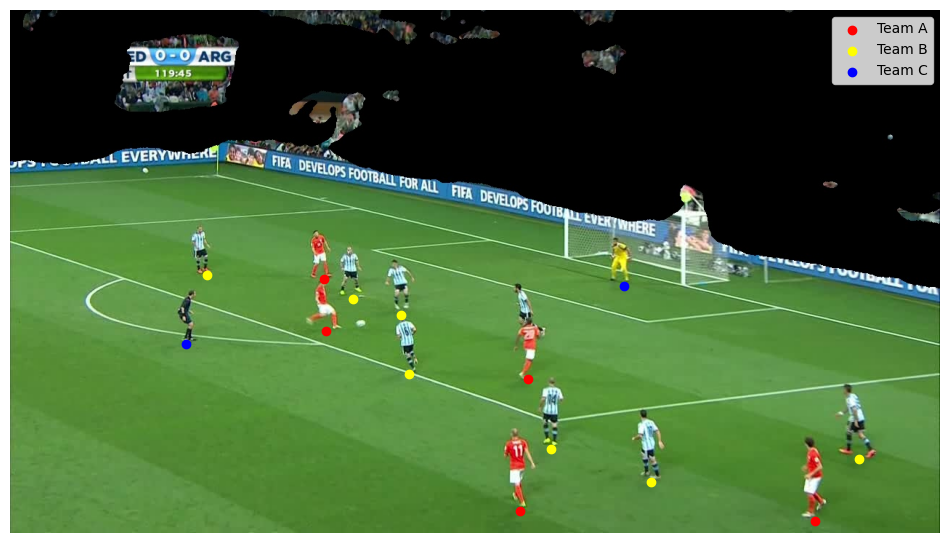

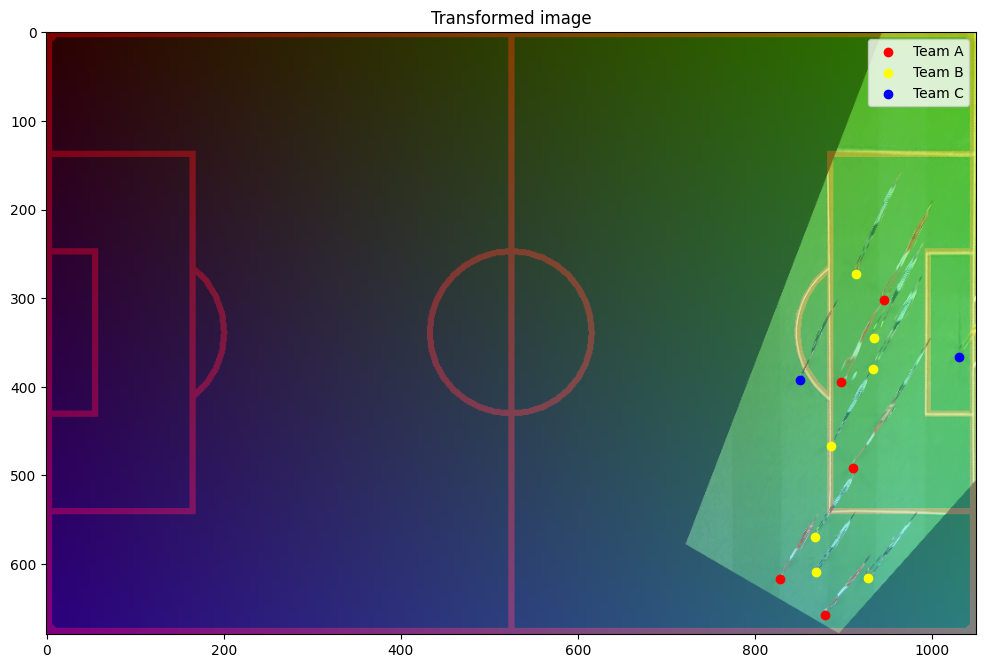

In [ ]:


group1_coordinates = source_points
group2_coordinates = source_points2
group3_coordinates = source_points3

# Combine all coordinates
all_coordinates = np.vstack((group1_coordinates, group2_coordinates, group3_coordinates))

# Plot original points
plt.figure(figsize=(12, 8))
plt.imshow(imageio.v2.imread(apt.goal_image_path, pilmode='RGB'))
plt.scatter(group1_coordinates[:, 0], group1_coordinates[:, 1], color='red', label='Team A')
plt.scatter(group2_coordinates[:, 0], group2_coordinates[:, 1], color='yellow', label='Team B')
plt.scatter(group3_coordinates[:, 0], group3_coordinates[:, 1], color='blue', label='Team C')
plt.legend()
plt.axis("off")
# plt.title("Original Image")
plt.show()

# Normalize coordinates
x = torch.tensor(all_coordinates[:, 0] / imageio.v2.imread(apt.goal_image_path, pilmode='RGB').shape[1] - 0.5).float()
y = torch.tensor(all_coordinates[:, 1] / imageio.v2.imread(apt.goal_image_path, pilmode='RGB').shape[0] - 0.5).float()
xy = torch.stack([x, y, torch.ones_like(x)], dim=1)

# Apply homography
xy_warped = torch.matmul(optim_homography.cpu(), xy.T).T
xy_warped, z_warped = xy_warped.split([2, 1], dim=1)

# Normalize by z coordinate
xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
x_warped, y_warped = torch.unbind(xy_warped, dim=1)

# Convert to image coordinates
x_warped = (x_warped * 0.5 + 0.5) * 1050
y_warped = (y_warped * 0.5 + 0.5) * 680

# Detach tensors and convert to numpy arrays
x_warped_np = x_warped.detach().cpu().numpy()
y_warped_np = y_warped.detach().cpu().numpy()

# Detach tensors and convert to numpy arrays
x_warped_np = x_warped.detach().cpu().numpy()
y_warped_np = y_warped.detach().cpu().numpy()

# Combine x and y coordinates
warped_coordinates = np.column_stack((x_warped_np, y_warped_np))

# Split warped coordinates into groups
group1_warped = warped_coordinates[:len(group1_coordinates)]
group2_warped = warped_coordinates[len(group1_coordinates):len(group1_coordinates)+len(group2_coordinates)]
group3_warped = warped_coordinates[len(group1_coordinates)+len(group2_coordinates):]

#Plot warped points
plt.figure(figsize=(12, 8))
plt.imshow(torch_img_to_np_img(warped_frm)*0.5 + torch_img_to_np_img(template_image_draw)*0.5)
plt.scatter(x_warped_np[:len(group1_coordinates)], y_warped_np[:len(group1_coordinates)], color='red', label='Team A')
plt.scatter(x_warped_np[len(group1_coordinates):len(group1_coordinates)+len(group2_coordinates)],
            y_warped_np[len(group1_coordinates):len(group1_coordinates)+len(group2_coordinates)], color='yellow', label='Team B')
plt.scatter(x_warped_np[len(group1_coordinates)+len(group2_coordinates):],
            y_warped_np[len(group1_coordinates)+len(group2_coordinates):], color='blue', label='Team C')
plt.legend()
plt.title("Transformed image")
plt.show()

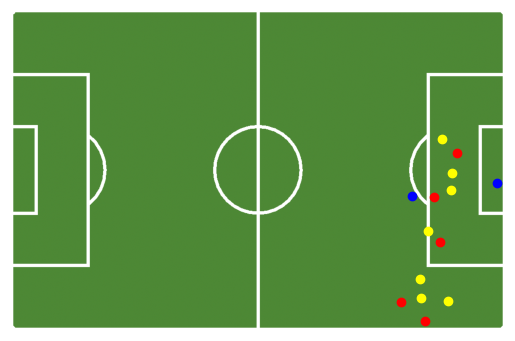

In [ ]:
template_image = imageio.v2.imread(apt.template_path, pilmode='RGB')
template_image = template_image / 255.0

plt.scatter(group1_warped[:, 0], group1_warped[:, 1], color='red', label='Group 1')
plt.scatter(group2_warped[:, 0], group2_warped[:, 1], color='yellow', label='Group 2')
plt.scatter(group3_warped[:, 0], group3_warped[:, 1], color='blue', label='Group 3')

plt.imshow(template_image)
plt.axis('off')
plt.show()